<a href="https://colab.research.google.com/github/StefanoDiscetti/MPC_examples/blob/main/nmpc_casadi_LS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nonlinear Model Predictive Control (NMPC) of the Actuated Lorenz System

### Problem Overview

This notebook implements a **Nonlinear Model Predictive Control (NMPC)** strategy to stabilize a chaotic nonlinear dynamical system: the **Lorenz system with additive control inputs**.

The objective here is to compute, at each time step, an optimal control sequence that drives the system from an arbitrary initial condition to a desired equilibrium point and stabilizes it there.

---

### Controlled Dynamical System

The controlled Lorenz system is defined as:

$$
\dot{x} = f(x) + u
$$

where:

$$
x =
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
\quad , \quad
u =
\begin{bmatrix}
u_1 \\
u_2 \\
u_3
\end{bmatrix}
$$

and the nonlinear vector field is:

$$
f(x) =
\begin{bmatrix}
\sigma (x_2 - x_1) \\
x_1 (\rho - x_3) - x_2 \\
x_1 x_2 - \beta x_3
\end{bmatrix}
$$

The parameters are selected in the chaotic regime:

- $\sigma = 10$  
- $\rho = 28$  
- $\beta = 8/3$  

The control input acts directly on each state equation.

---

### Control Objective

The goal is to stabilize the system at the target ($x^*$), represented by one of its unstable equilibrium points:

$$
E_0 =
\begin{bmatrix}
0 \\ 0 \\ 0
\end{bmatrix}
\qquad
E_1 =
\begin{bmatrix}
\sqrt{\beta(\rho-1)} \\
\sqrt{\beta(\rho-1)} \\
\rho - 1
\end{bmatrix}
\qquad
E_2 =
\begin{bmatrix}
-\sqrt{\beta(\rho-1)} \\
-\sqrt{\beta(\rho-1)} \\
\rho - 1
\end{bmatrix}
$$


---

### Optimization Problem

The NMPC problem minimizes the following objective:

$$
J =
\sum_{k=0}^{N-1}
(x_k - x^*)^T Q (x_k - x^*)
+
u_k^T R u_k
+
(x_N - x^*)^T Q_f (x_N - x^*)
$$

subject to:

**System dynamics (discretized with RK4):**

$$
x_{k+1} = \mathrm{RK4}(x_k, u_k)
$$

**Control constraints:**

$$
u_{\min} \le u_k \le u_{\max}
$$

**Initial condition (measured state feedback):**

$$
x_0 = x_{\mathrm{current}}
$$

---

In [1]:
# ---------------------------------------------------------
# 0. CASADI INSTALLATION
# ---------------------------------------------------------
!pip -q install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.7 MB/s eta 0:00:00


LQR Gain K calculated at target [0 0 0]:
[[17.51685229 12.93936123  0.        ]
 [12.93936123 12.86939637  0.        ]
 [ 0.          0.          7.68278313]]
Starting Simulation from x0 = [-4.00197975 -3.48663314 -3.14264973]...
Step 0/200 completed.
Step 10/200 completed.
Step 20/200 completed.
Step 30/200 completed.
Step 40/200 completed.
Step 50/200 completed.
Step 60/200 completed.
Step 70/200 completed.
Step 80/200 completed.
Step 90/200 completed.
Step 100/200 completed.
Step 110/200 completed.
Step 120/200 completed.
Step 130/200 completed.
Step 140/200 completed.
Step 150/200 completed.
Step 160/200 completed.
Step 170/200 completed.
Step 180/200 completed.
Step 190/200 completed.


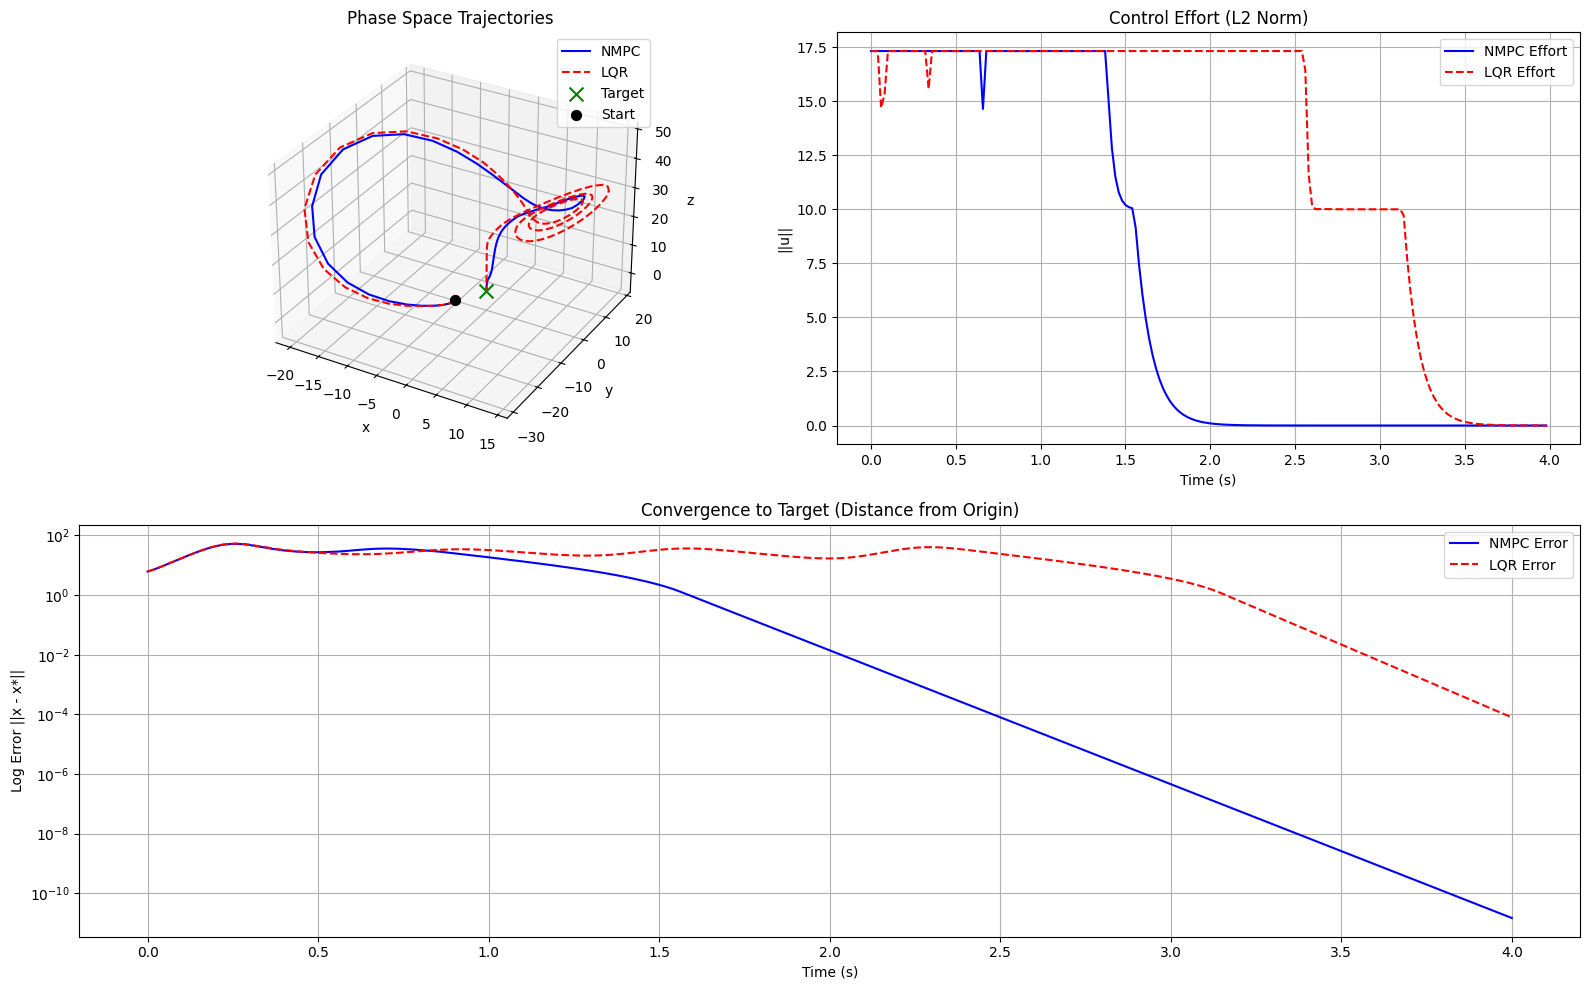

Total Cost NMPC: 54603.43
Total Cost LQR : 114887.01


In [8]:
# -*- coding: utf-8 -*-
"""NMPC_vs_LQR_Lorenz.ipynb

Automatically generated by Colab.
"""

# ---------------------------------------------------------
# 0. INSTALL CASADI & IMPORTS
# ---------------------------------------------------------
!pip -q install casadi

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from mpl_toolkits.mplot3d import Axes3D

# ---------------------------------------------------------
# 1. PARAMETERS & SYSTEM DEFINITION
# ---------------------------------------------------------
nx = 3   # State dimension (x, y, z)
nu = 3   # Control dimension (u1, u2, u3)

# Lorenz physical constants (Chaotic regime)
sigma = 10.0
rho   = 28.0
beta  = 8.0/3.0
dt    = 0.02  # Integration time step
N     = 50    # NMPC Prediction horizon (1.0 second look-ahead)

def lorenz_vector_field(x, u):
    """Defines the ODEs for the actuated Lorenz system."""
    x1, x2, x3 = x[0], x[1], x[2]
    # Natural dynamics + Control input
    f = ca.vertcat(
        sigma*(x2 - x1),
        x1*(rho - x3) - x2,
        x1*x2 - beta*x3
    )
    return f + u

# CasADi function for the model (used by NMPC)
x_sx = ca.SX.sym("x", nx)
u_sx = ca.SX.sym("u", nu)
f_model = ca.Function("f_model", [x_sx, u_sx], [lorenz_vector_field(x_sx, u_sx)])

def rk4_step_np(x, u, dt):
    """Runge-Kutta 4th order integration step (Numpy version for simulation loop)."""
    # Helper lambda for dynamics
    def f_dyn(xv, uv):
        x1, x2, x3 = xv[0], xv[1], xv[2]
        fv = np.array([
            sigma*(x2 - x1),
            x1*(rho - x3) - x2,
            x1*x2 - beta*x3
        ])
        return fv + uv

    k1 = f_dyn(x, u)
    k2 = f_dyn(x + dt/2 * k1, u)
    k3 = f_dyn(x + dt/2 * k2, u)
    k4 = f_dyn(x + dt * k3, u)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def rk4_step_ca(f, x, u, dt):
    """Runge-Kutta 4th order integration step (CasADi version for NMPC)."""
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


# ---------------------------------------------------------
# 2. SETPOINTS & TARGETS
# ---------------------------------------------------------
# Calculate Fixed Points (Equilibria)
E_0    = np.array([0, 0, 0])
# We will target the origin E_0
x_star_np = E_0
x_star_ca = ca.DM(x_star_np)

# Common Cost Weights (used for both NMPC and LQR)
Q_diag = np.array([1.0, 1.0, 1.0])
R_diag = np.array([0.01, 0.01, 0.01])

# Input constraints
u_min_val = -10.0
u_max_val = 10.0
umin = [u_min_val]*nu
umax = [u_max_val]*nu


# ---------------------------------------------------------
# 3. LQR CONTROLLER SETUP
# ---------------------------------------------------------
def get_linearized_model(sigma, rho, beta, x_eq):
    """
    Returns A and B matrices for Lorenz system linearized at x_eq.
    """
    x1, x2, x3 = x_eq[0], x_eq[1], x_eq[2]

    # Jacobian df/dx evaluated at x_eq
    A = np.array([
        [-sigma,   sigma,    0      ],
        [rho - x3, -1,       -x1    ],
        [x2,       x1,       -beta  ]
    ])

    # Jacobian df/du (identity since u is additive)
    B = np.eye(3)
    return A, B

# 1. Linearize at Target
A_lin, B_lin = get_linearized_model(sigma, rho, beta, x_star_np)

# 2. Solve Riccati Equation
Q_lqr = np.diag(Q_diag)
R_lqr = np.diag(R_diag)
P_lqr = solve_continuous_are(A_lin, B_lin, Q_lqr, R_lqr)

# 3. Compute LQR Gain K
K_lqr = np.linalg.inv(R_lqr) @ B_lin.T @ P_lqr
print(f"LQR Gain K calculated at target {x_star_np}:\n{K_lqr}")


# ---------------------------------------------------------
# 4. NMPC CONTROLLER SETUP
# ---------------------------------------------------------
opti = ca.Opti()

X = opti.variable(nx, N+1)  # States over horizon
U = opti.variable(nu, N)    # Controls over horizon
X0 = opti.parameter(nx)     # Initial State
XSTAR = opti.parameter(nx)  # Target State

# Cost Matrices
Q_ca = ca.diag(ca.DM(Q_diag))
R_ca = ca.diag(ca.DM(R_diag))

# Objective
obj = 0
for k in range(N):
    err = X[:, k] - XSTAR
    obj += ca.mtimes([err.T, Q_ca, err]) + ca.mtimes([U[:, k].T, R_ca, U[:, k]])
# Terminal Cost
err_N = X[:, N] - XSTAR
obj += ca.mtimes([err_N.T, Q_ca, err_N])
opti.minimize(obj)

# Constraints
opti.subject_to(X[:, 0] == X0)
for k in range(N):
    opti.subject_to(X[:, k+1] == rk4_step_ca(f_model, X[:, k], U[:, k], dt))
    opti.subject_to(opti.bounded(umin, U[:, k], umax))

# Solver Options
opts = {
    "print_time": 0,
    "ipopt.print_level": 0,
    "ipopt.sb": "yes",
    "ipopt.max_iter": 500
}
opti.solver("ipopt", opts)
opti.set_value(XSTAR, x_star_ca)


# ---------------------------------------------------------
# 5. SIMULATION LOOP (PARALLEL)
# ---------------------------------------------------------
T_sim = 4.0
K_sim = int(T_sim / dt)

# Random Initial Condition (Same for both)
# Start slightly far away to see difference in transient response
xk_init = np.random.uniform(-5, 5, size=3)

# --- NMPC Initialization ---
x_nmpc = xk_init.copy()
X_log_nmpc = np.zeros((K_sim+1, nx))
U_log_nmpc = np.zeros((K_sim, nu))
X_log_nmpc[0, :] = x_nmpc

# --- LQR Initialization ---
x_lqr = xk_init.copy()
X_log_lqr = np.zeros((K_sim+1, nx))
U_log_lqr = np.zeros((K_sim, nu))
X_log_lqr[0, :] = x_lqr

t_log = np.arange(K_sim+1) * dt

print(f"Starting Simulation from x0 = {xk_init}...")

for k in range(K_sim):
    # ==========================
    # A. NMPC Step
    # ==========================
    opti.set_value(X0, x_nmpc)
    try:
        sol = opti.solve()
        u_nmpc = sol.value(U[:, 0])
        # Warm start
        opti.set_initial(U, np.hstack([sol.value(U)[:, 1:], sol.value(U)[:, -1:]]))
        opti.set_initial(X, np.hstack([sol.value(X)[:, 1:], sol.value(X)[:, -1:]]))
    except:
        # Fallback if solver fails
        u_nmpc = np.zeros(nu)

    # Apply NMPC control
    x_nmpc = rk4_step_np(x_nmpc, u_nmpc, dt)

    X_log_nmpc[k+1, :] = x_nmpc
    U_log_nmpc[k, :] = u_nmpc

    # ==========================
    # B. LQR Step
    # ==========================
    error_lqr = x_lqr - x_star_np
    u_lqr = -K_lqr @ error_lqr

    # CLIP LQR control to be fair (NMPC has hard constraints)
    u_lqr = np.clip(u_lqr, u_min_val, u_max_val)

    # Apply LQR control
    x_lqr = rk4_step_np(x_lqr, u_lqr, dt)

    X_log_lqr[k+1, :] = x_lqr
    U_log_lqr[k, :] = u_lqr

    if k % 10 == 0:
        print(f"Step {k}/{K_sim} completed.")

# ---------------------------------------------------------
# 6. VISUALIZATION & COMPARISON
# ---------------------------------------------------------
fig = plt.figure(figsize=(16, 10))

# 1. 3D Trajectory Comparison
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(X_log_nmpc[:, 0], X_log_nmpc[:, 1], X_log_nmpc[:, 2], 'b-', label='NMPC', lw=1.5)
ax1.plot(X_log_lqr[:, 0], X_log_lqr[:, 1], X_log_lqr[:, 2], 'r--', label='LQR', lw=1.5)
ax1.scatter(*x_star_np, color='green', marker='x', s=100, label='Target')
ax1.scatter(*xk_init, color='black', marker='o', s=50, label='Start')
ax1.set_title("Phase Space Trajectories")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.legend()

# 2. Control Effort Comparison (Norm)
ax2 = fig.add_subplot(222)
u_norm_nmpc = np.linalg.norm(U_log_nmpc, axis=1)
u_norm_lqr = np.linalg.norm(U_log_lqr, axis=1)
ax2.plot(t_log[:-1], u_norm_nmpc, 'b-', label='NMPC Effort')
ax2.plot(t_log[:-1], u_norm_lqr, 'r--', label='LQR Effort')
ax2.set_title("Control Effort (L2 Norm)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("||u||")
ax2.grid(True)
ax2.legend()

# 3. State Error Convergence (Log Scale)
ax3 = fig.add_subplot(212)
err_nmpc = np.linalg.norm(X_log_nmpc - x_star_np, axis=1)
err_lqr  = np.linalg.norm(X_log_lqr - x_star_np, axis=1)
ax3.semilogy(t_log, err_nmpc, 'b-', label='NMPC Error')
ax3.semilogy(t_log, err_lqr, 'r--', label='LQR Error')
ax3.set_title("Convergence to Target (Distance from Origin)")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Log Error ||x - x*||")
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Calculate Total Cost for comparison
cost_nmpc = np.sum(np.diag(X_log_nmpc @ np.diag(Q_diag) @ X_log_nmpc.T)) + np.sum(np.diag(U_log_nmpc @ np.diag(R_diag) @ U_log_nmpc.T))
cost_lqr = np.sum(np.diag(X_log_lqr @ np.diag(Q_diag) @ X_log_lqr.T)) + np.sum(np.diag(U_log_lqr @ np.diag(R_diag) @ U_log_lqr.T))

print(f"Total Cost NMPC: {cost_nmpc:.2f}")
print(f"Total Cost LQR : {cost_lqr:.2f}")
